<a href="https://colab.research.google.com/github/Crayfi/Datasets/blob/main/Current_Multivariate_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

from scipy.ndimage.interpolation import shift

In [6]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found


In [7]:
#@title Version Info
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

tf version:  2.6.0
tf.keras version: 2.6.0


In [8]:
#@title Time
!pip install ipython-autotime

%load_ext autotime

time: 144 µs (started: 2021-10-21 04:21:42 +00:00)


In [9]:
#@title Variables

stepsForward = 4
stepsBack = 10
trainTestSplit = 0.75
LSTMoutputDimension = 50

time: 2.89 ms (started: 2021-10-21 04:21:42 +00:00)


In [35]:
# open database try the processed file first, process if needed
try:
  file = open('buy_average_fill_clean.csv', 'r')
  df = pd.read_csv(file, error_bad_lines=False)
  file = open('buy_quantity_clean.csv', 'r')
  df_buy_quantity = pd.read_csv(file, error_bad_lines=False)
except:
  try:
    file = open('buy_average_fill.csv', 'r')
    df = pd.read_csv(file, error_bad_lines=False)
    file2 = open('buy_quantity.csv', 'r')
    df_buy_quantity = pd.read_csv(file2, error_bad_lines=False)
    #make first row of quantity 1s
    df_buy_quantity.iloc[0] = [1]*len(df_buy_quantity.columns)
    #remove duplicate entries
    drop = []
    for i in range(1, len(df)):
      duplicates = [df.values[i][x] == df.values[i-1][x] for x in range(2, len(df.columns)) ]
      if np.all(duplicates):
        drop.append(i)
    for i in drop:
      df = df.drop([i])
      df_buy_quantity = df_buy_quantity.drop([i])
      
    df.to_csv('buy_average_fill_clean.csv')
    df_buy_quantity.to_csv('buy_quantity_clean.csv')
  except:
    try:
      file = open('buy_average.csv', 'r')
      df = pd.read_csv(file, error_bad_lines=False)

      def fill_zeros(x):
        # make first row all 1s
        x.iloc[0] = [1]*len(x.columns)

        # fill zeros in with previous price
        for i in x.columns:
          for j in range(len(x)):
            #TODO update with historical data later
            if (x[i][j] == 0 ):
              x[i][j] = x[i][j-1]
        return x

      df = fill_zeros(df)
      df.to_csv('buy_average_fill.csv')
    except:
      print('Can\'t locate buy_average or buy_quantity ')

time: 1.32 s (started: 2021-10-21 04:32:39 +00:00)


In [36]:
df

,Unnamed: 0,timestamp,Cannonball,Cannon_base,Cannon_stand,Cannon_barrels,Cannon_furnace,Insect_repellent,Bucket_of_wax,Candle,Bronze_arrowtips,Iron_arrowtips,Steel_arrowtips,Mithril_arrowtips,Adamant_arrowtips,Rune_arrowtips,Opal_bolt_tips,Pearl_bolt_tips,Barb_bolttips,Longbow_(u),Shortbow_(u),Arrow_shaft,Headless_arrow,Oak_shortbow_(u),Oak_longbow_(u),Willow_longbow_(u),Willow_shortbow_(u),Maple_longbow_(u),Maple_shortbow_(u),Yew_longbow_(u),Yew_shortbow_(u),Magic_longbow_(u),Magic_shortbow_(u),Guam_potion_(unf),Marrentill_potion_(unf),Tarromin_potion_(unf),Harralander_potion_(unf),Ranarr_potion_(unf),Irit_potion_(unf),Avantoe_potion_(unf),...,Gadderhammer,Toy_soldier,Staff_of_balance,Toy_soldier_(wound),Toy_doll,Toy_doll_(wound),Toy_mouse,Toy_mouse_(wound),Toy_cat,Snake_hide.1,Trouver_parchment,Swift_blade,Ornate_maul_handle,Wilderness_crabs_teleport,Basilisk_jaw,Dagon'hai_hat,Dagon'hai_robe_top,Dagon'hai_robe_bottom,Bottle_of_wine,Pure_essence,Tortoise_shell,Raw_monkfish,Monkfish,Dagon'hai_robes_set,Bounty_target_teleport,Varrock_teleport,Lumbridge_teleport,Falador_teleport,Camelot_teleport,Ardougne_teleport,Watchtower_teleport,Teleport_to_house,Bones_to_bananas,Bones_to_peaches,Enchant_sapphire_or_opal,Enchant_emerald_or_jade,Enchant_ruby_or_topaz,Enchant_diamond,Enchant_dragonstone,Enchant_onyx
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1580705282,191,195000,192999,198668,197999,1,774,295,1,5,1,1,171,202,1,1,1,1,1,1,8,1,1,1,1,1,79,243,1,1015,1,103,1,235,743,9943,1040,1,...,1,1,1,1,1,1,1,1,1,1,864998,1,539457,1,31760740,1,1,1,1,3,1,360,426,1,1,474,493,428,206,438,1,535,1,1165,1,1,1,1,1,1
2,4,1580705461,192,195000,192999,198668,197999,1,774,295,1,5,1,1,171,202,1,1,1,1,1,1,8,1,1,1,1,64,79,244,1,1015,1,103,1,235,742,9942,1040,1890,...,1,1,1,1,1,1,1,1,1,1,864998,1,540482,23500,31760740,1,1,1,1,3,1,360,426,1,1,474,493,428,206,438,1,528,1,1165,1,1,1,1,1,1
3,9,1580705761,191,195000,192999,198668,197999,1,774,295,3,5,1,1,171,202,1,1,1,1,1,1,8,1,1,1,1,64,79,244,1,1015,1,103,1,235,742,9943,1040,1890,...,1,1,1,1,1,1,1,1,1,1,864998,1,542578,23500,31760740,1,1,1,1,3,1,360,426,1,1,474,493,427,206,438,1,528,1,1155,1,1,1,1,1,1
4,13,1580706121,191,191243,192999,198668,197999,1,774,295,3,5,1,1,171,202,1,1,1,1,1,1,9,1,20,1,1,64,79,244,1,1015,1,103,1,235,742,9954,1040,1890,...,1,1,1,1,1,1,1,1,1,1,864998,1,542710,23500,31750847,1,1,1,1,3,1,360,426,1,1,474,493,427,206,438,1,528,1,1155,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,2825,1581043561,181,188699,196189,189374,187239,980,625,232,3,5,34,40,138,209,7,8,1,22,3,1,9,10,30,19,33,58,69,237,166,1006,835,98,58,250,761,9987,1033,1738,...,7000,8700,18379999,1,1701,1,806,1345,3350,235,912942,12750000,527908,22350,36560784,3057143,9487000,4317412,1,2,1,342,424,17739999,9333,529,494,389,199,412,343,449,598,1074,455,1,477,1,2,1
1131,2828,1581043921,181,188699,196189,189374,184979,980,625,232,3,10,34,40,138,209,7,8,1,22,3,1,9,10,30,19,33,58,69,237,166,1006,835,97,58,250,761,9983,1033,1738,...,7000,8700,18379999,1,1701,1,806,1345,3350,235,912942,12750000,525998,22350,36560784,3057143,9487000,4317412,1,2,1,342,425,17739999,9333,530,494,389,199,412,343,449,598,1080,455,1,477,1,2,1
1132,2830,1581044162,181,188699,196189,189374,184979,980,625,232,3,10,34,40,138,209,7,8,1,22,3,1,9,10,30,19,33,58,69,237,166,1006,835,97,58,250,752,9983,1033,1800,...,7000,8700,18379999,1,1701,1,806,1345,3350,235,915632,12750000,525283,22350,36560784,3057143,9487000,4317412,1,2,1,342,424,17739999,9333,530,494,388,199,412,343,450,598,1083,455,1,477,1,2,1
1133,2833,1581044521,181,188699,196189,189374,184979,980

time: 123 ms (started: 2021-10-21 04:32:40 +00:00)


In [37]:
# Replace Cannonball with any item name in df
# drop first row of 1s
df_item = pd.DataFrame(df.Cannonball).values[1:]
df_buy_quantity = df_buy_quantity.Cannonball.values[1:]

# calculate change in flow per trade
flow = np.multiply(df_item[:], df_buy_quantity[:])


# Fit values between 0 and 1
# TODO: make function to accept list of items with different models each
minmax_price = MinMaxScaler().fit(df_item.reshape((-1,1)))
df_price = minmax_price.transform(df_item.reshape((-1,1)))

minmax_buy_quant = MinMaxScaler().fit(df_buy_quantity.reshape((-1,1)))
df_buy_quant_normalize = minmax_buy_quant.transform(df_buy_quantity.reshape((-1,1)))

minmax_flow = MinMaxScaler().fit(flow.reshape((-1,1)))
df_flow = minmax_flow.transform(flow.reshape((-1,1)))
for i in range(len(df_flow)):
  df_flow[i] = float(df_flow[i])

df_normalize = list(zip(df_price, df_buy_quant_normalize, df_flow))

def walk_forward(X, stepsBack, stepsForward, trainTestSplit):
  n_records = len(X)
  dfx = X.copy()
  split = int(n_records*trainTestSplit-stepsForward)
  x = []
  y = []
  for i in range(n_records):
    x.append(dfx[i : i + stepsBack])  
    y.append(dfx[i + stepsBack : i + stepsBack + stepsForward,0])

  xtrain = x[:split-stepsBack]
  ytrain = y[:split-stepsBack]

  xtest = x[split: n_records - stepsBack]
  ytest = y[split: n_records - stepsBack]
	
  return np.asarray(xtrain), np.asarray(ytrain), np.asarray(xtest), np.asarray(ytest)

X_train, y_train, X_test, y_test = walk_forward(np.copy(df_normalize), stepsBack, stepsForward, trainTestSplit)

#print('train=%d, test=%d' % (len(X_train), len(X_test))) 

X_train = np.reshape(X_train,(len(X_train),stepsBack,len(X_train[0][0])))
X_test = np.reshape(X_test,(len(X_test),stepsBack,len(X_test[0][0])))

# pad the output to equal the input
y_train_padded = pad_sequences(np.array(y_train), maxlen= stepsBack, 
                               padding='post', dtype='float32')
y_test_padded = pad_sequences(np.array(y_test), maxlen= stepsBack, 
                               padding='post', dtype='float32')

time: 1.16 s (started: 2021-10-21 04:32:40 +00:00)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [38]:
X_train[:1]

array([[[0.77777778, 0.50800598, 0.50191192],
        [0.83333333, 0.46853619, 0.46384873],
        [0.77777778, 0.33656765, 0.33658323],
        [0.77777778, 0.35003102, 0.3495668 ],
        [0.72222222, 0.38250053, 0.38087917],
        [0.72222222, 0.41396643, 0.4112237 ],
        [0.72222222, 0.39751721, 0.39536069],
        [0.72222222, 0.42371519, 0.42062504],
        [0.72222222, 0.39275318, 0.39076644],
        [0.66666667, 0.37920652, 0.37770255]]])

time: 6.96 ms (started: 2021-10-21 04:32:42 +00:00)


In [39]:
X_train[:1]

array([[[0.77777778, 0.50800598, 0.50191192],
        [0.83333333, 0.46853619, 0.46384873],
        [0.77777778, 0.33656765, 0.33658323],
        [0.77777778, 0.35003102, 0.3495668 ],
        [0.72222222, 0.38250053, 0.38087917],
        [0.72222222, 0.41396643, 0.4112237 ],
        [0.72222222, 0.39751721, 0.39536069],
        [0.72222222, 0.42371519, 0.42062504],
        [0.72222222, 0.39275318, 0.39076644],
        [0.66666667, 0.37920652, 0.37770255]]])

time: 4.93 ms (started: 2021-10-21 04:32:42 +00:00)


In [40]:
# decoder input data
# [1, [0]*len(sequence)] - start sequence
# [0, pred_sequence] - followed by predict sequences
# ...
# [0, [0]*len(sequence)] - end sequence

def decoder_data(x):
  df = x.copy()
  new_df = np.zeros((len(df)-stepsBack,stepsBack,stepsBack))
  for i in range(len(df)-stepsBack):
    # following predictions
    for j in range(1, stepsBack): # leave first row as 0s for start  
      for k in range(stepsBack):
        new_df[i,j,k] = float(df[j-1,k])

  return new_df

def transform_ydata(x):
  df = x.copy()
  new_df = np.zeros((len(df)-stepsBack,stepsBack,stepsBack))
  for i in range(len(df)-stepsBack):
    for j in range(stepsBack):
      for k in range(stepsBack):
        new_df[i,j,k] = float(df[j,k])

  return new_df

def transform_xdata(x,price):
  price_df = price.copy()
  df = x.copy()
  new_df = np.zeros((len(df)-stepsBack,stepsBack,stepsBack+len(df[0][0])-1))
  for i in range(len(df)-stepsBack):
    for j in range(stepsBack):
      #sequences
      for k in range(stepsBack):
        new_df[i,j,k] = float(df[i+j,k,0])
      #features
      for l in range(len(df[0][0])-1):
        new_df[i,j,stepsBack+l] = float(df[i,j,l+1])

  return new_df

y_train_decode = decoder_data(y_train_padded)
y_test_decode = decoder_data(y_test_padded)

X_train = transform_xdata(X_train, df_price)
X_test = transform_xdata(X_test, df_price)
y_train_padded = transform_ydata(y_train_padded)
y_test_padded = transform_ydata(y_test_padded)

y_train_decode = tf.convert_to_tensor(y_train_decode, dtype = tf.float32)
y_test_decode = tf.convert_to_tensor(y_test_decode, dtype = tf.float32)
X_train = tf.convert_to_tensor(X_train, dtype = tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype = tf.float32)
y_train_padded = tf.convert_to_tensor(y_train_padded, dtype = tf.float32)
y_test_padded = tf.convert_to_tensor(y_test_padded, dtype = tf.float32)

time: 276 ms (started: 2021-10-21 04:32:42 +00:00)


In [41]:
X_train[:1]

<tf.Tensor: shape=(1, 10, 12), dtype=float32, numpy=
array([[[0.7777778 , 0.8333333 , 0.7777778 , 0.7777778 , 0.7222222 ,
         0.7222222 , 0.7222222 , 0.7222222 , 0.7222222 , 0.6666667 ,
         0.508006  , 0.50191194],
        [0.8333333 , 0.7777778 , 0.7777778 , 0.7222222 , 0.7222222 ,
         0.7222222 , 0.7222222 , 0.7222222 , 0.6666667 , 0.6111111 ,
         0.4685362 , 0.46384874],
        [0.7777778 , 0.7777778 , 0.7222222 , 0.7222222 , 0.7222222 ,
         0.7222222 , 0.7222222 , 0.6666667 , 0.6111111 , 0.6111111 ,
         0.33656764, 0.33658323],
        [0.7777778 , 0.7222222 , 0.7222222 , 0.7222222 , 0.7222222 ,
         0.7222222 , 0.6666667 , 0.6111111 , 0.6111111 , 0.6111111 ,
         0.35003102, 0.3495668 ],
        [0.7222222 , 0.7222222 , 0.7222222 , 0.7222222 , 0.7222222 ,
         0.6666667 , 0.6111111 , 0.6111111 , 0.6111111 , 0.6111111 ,
         0.38250053, 0.38087916],
        [0.7222222 , 0.7222222 , 0.7222222 , 0.7222222 , 0.6666667 ,
         0.6111111

time: 10.5 ms (started: 2021-10-21 04:32:42 +00:00)


In [42]:
y_train_decode[825:]

<tf.Tensor: shape=(1, 10, 10), dtype=float32, numpy=
array([[[0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.6111111, 0.6111111, 0.6111111, 0.6111111, 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.6111111, 0.6111111, 0.6111111, 0.6111111, 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.6111111, 0.6111111, 0.6111111, 0.6666667, 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.6111111, 0.6111111, 0.6666667, 0.6666667, 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.6111111, 0.6666667, 0.6666667, 0.6666667, 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.6666667, 0.6666667, 0.6666667, 0.6666667, 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.6666667, 0.6666667, 0.6666667, 0.

time: 6.82 ms (started: 2021-10-21 04:32:42 +00:00)


In [48]:
# define the model
encoder_inputs= Input(shape=(stepsBack, len(X_train[0][0])), name='encoder_inputs')
#mask = np.zeros((stepsBack+1))
#mask[0] = 1
masking = tf.keras.layers.Masking(mask_value= [0,0,0,0,0,0,0,0,0,0,0,0])
encoder_inputs_masked = masking(encoder_inputs)


encoder_lstm1=LSTM(LSTMoutputDimension, return_sequences=True, name='encoder_lstm1')
LSTM_outputs = encoder_lstm1(encoder_inputs_masked)
LSTM_outputs = TimeDistributed(Dense(stepsBack)) (LSTM_outputs)
encoder_lstm2=LSTM(LSTMoutputDimension, return_state=True, name='encoder_lstm2')
LSTM_outputs, state_h, state_c = encoder_lstm2(LSTM_outputs)

# We discard `LSTM_outputs` and only keep the other states.
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(stepsBack, stepsBack), name='decoder_inputs')

decoder_lstm1 = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm1')

# Set up the decoder, using `context vector` as initial state.
decoder1_outputs, _, _= decoder_lstm1(decoder_inputs,
                                     initial_state=encoder_states)
decoder_lstm2 = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm2')
decoder_outputs, _, _ = decoder_lstm2(decoder1_outputs)

#complete the decoder model by adding a Dense layer with Softmax activation function 
#for prediction of the next output
#Dense layer will output one-hot encoded representation as we did for input
#Therefore, we will use input_dimension number of neurons
decoder_dense = TimeDistributed(Dense(stepsBack, activation='LeakyReLU', name='decoder_dense'))
decoder_outputs = decoder_dense(decoder_outputs)

# put together
model_encoder_training = Model([encoder_inputs, decoder_inputs], 
                               decoder_outputs, name='model_encoder_training')
'''
def loss_fun1(y_true, y_pred):
    
    loss  = tf.nn.sigmoid_cross....
    return loss

def loss_fun2(y_true, y_pred):
     # do whatever you want
    loss  = tf.nn.sigmoid_cross....
    return loss

def loss_fun3(y_true, y_pred):
     # do whatever you want
    loss  = tf.nn.sigmoid_cross....
    return loss

losses ={'output_layer1':loss_fun1,
          'output_layer2':loss_fun2,
          'output_layer2':loss_fun3
        }

lossWeights={'output_layer1':0.5,
          'output_layer2':0.3,
          'output_layer3':0.2  
        }

target1 = tf.placeholder(dtype='float32', shape=(1)) # shapes of output1 your target has
target2 = tf.placeholder(dtype='float32', shape=(1)) # shapes of output2 your target has
target3 = tf.placeholder(dtype='float32', shape=(1))

model.compile(optimizer='rmsprop',
             loss=losses,
             loss_weights= lossWeights,
             target_tensors=[target1, target2, target3],
             metrics=['accuracy']                      
             )'''

"\ndef loss_fun1(y_true, y_pred):\n    \n    loss  = tf.nn.sigmoid_cross....\n    return loss\n\ndef loss_fun2(y_true, y_pred):\n     # do whatever you want\n    loss  = tf.nn.sigmoid_cross....\n    return loss\n\ndef loss_fun3(y_true, y_pred):\n     # do whatever you want\n    loss  = tf.nn.sigmoid_cross....\n    return loss\n\nlosses ={'output_layer1':loss_fun1,\n          'output_layer2':loss_fun2,\n          'output_layer2':loss_fun3\n        }\n\nlossWeights={'output_layer1':0.5,\n          'output_layer2':0.3,\n          'output_layer3':0.2  \n        }\n\ntarget1 = tf.placeholder(dtype='float32', shape=(1)) # shapes of output1 your target has\ntarget2 = tf.placeholder(dtype='float32', shape=(1)) # shapes of output2 your target has\ntarget3 = tf.placeholder(dtype='float32', shape=(1))\n\nmodel.compile(optimizer='rmsprop',\n             loss=losses,\n             loss_weights= lossWeights,\n             target_tensors=[target1, target2, target3],\n             metrics=['accuracy']

time: 2.33 s (started: 2021-10-21 04:33:11 +00:00)


In [49]:
def my_rmse(y_true, y_pred):
    error = 0
    for i in range(stepsForward):  
      #difference between true label and predicted label
      error += y_true[i]-y_pred[i]    
    #square of the error
    sqr_error = K.square(error)
    #mean of the square of the error
    mean_sqr_error = K.mean(sqr_error)
    #square root of the mean of the square of the error
    sqrt_mean_sqr_error = K.sqrt(mean_sqr_error)
    #return the error
    return sqrt_mean_sqr_error

time: 6.13 ms (started: 2021-10-21 04:33:19 +00:00)


Model: "model_encoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 10, 12)]     0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, 10, 12)       0           encoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            (None, 10, 50)       12600       masking_3[0][0]                  
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 10, 10)       510         encoder_lstm1[0][0]              
_____________________________________________________________________________

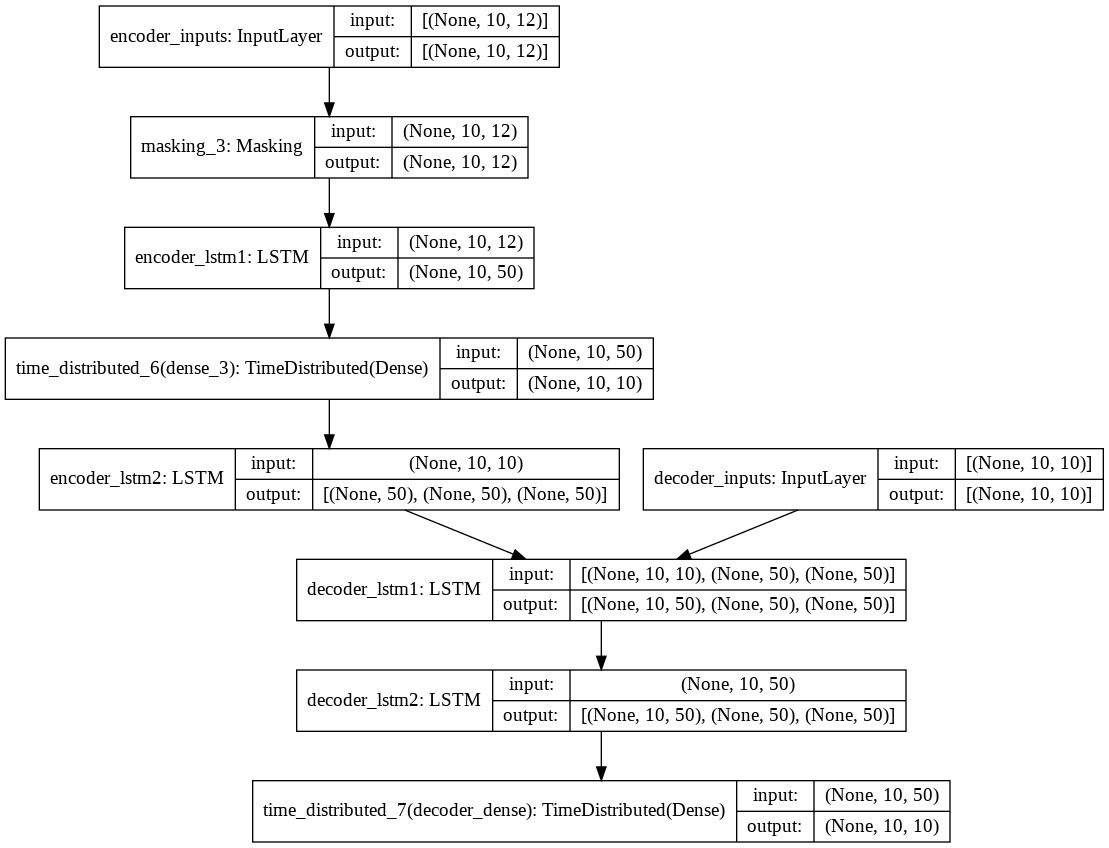

time: 168 ms (started: 2021-10-21 04:33:19 +00:00)


In [50]:
model_encoder_training.compile(optimizer='adam', loss=my_rmse, 
                               metrics=['accuracy'])
model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)

In [51]:
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_accuracy, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(y_test[0])
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (y_test[sample][0][0]== predicted[sample][0][0]):
			correct+=1
		#print( X_test[0][sample], ' ', 
					#y_test[sample],' ', predicted[sample],
					#' ',y_test[sample][0][0]== predicted[sample][0][0])
	print('Accuracy: ', correct/sampleNo)
	

time: 73.3 ms (started: 2021-10-21 04:33:19 +00:00)


training for  50  epochs begins with EarlyStopping(monitor= val_accuracy, patience= 3 )....
Epoch 1/50
83/83 - 15s - loss: 0.3495 - accuracy: 0.3396 - val_loss: 0.3892 - val_accuracy: 0.3269
Epoch 2/50
83/83 - 2s - loss: 0.0409 - accuracy: 0.4339 - val_loss: 0.4160 - val_accuracy: 0.3224
Epoch 3/50
83/83 - 2s - loss: 0.0326 - accuracy: 0.4333 - val_loss: 0.3959 - val_accuracy: 0.1989
Epoch 4/50
83/83 - 2s - loss: 0.0294 - accuracy: 0.4352 - val_loss: 0.4229 - val_accuracy: 0.3168
Epoch 5/50
83/83 - 2s - loss: 0.0276 - accuracy: 0.4355 - val_loss: 0.4384 - val_accuracy: 0.3709
Epoch 6/50
83/83 - 2s - loss: 0.0274 - accuracy: 0.4401 - val_loss: 0.4517 - val_accuracy: 0.2407
Epoch 7/50
83/83 - 2s - loss: 0.0264 - accuracy: 0.4360 - val_loss: 0.4527 - val_accuracy: 0.2280
Epoch 8/50
83/83 - 2s - loss: 0.0265 - accuracy: 0.4393 - val_loss: 0.4542 - val_accuracy: 0.2216
Epoch 9/50
83/83 - 2s - loss: 0.0257 - accuracy: 0.4340 - val_loss: 0.4616 - val_accuracy: 0.2873
Epoch 10/50
83/83 - 2s - 

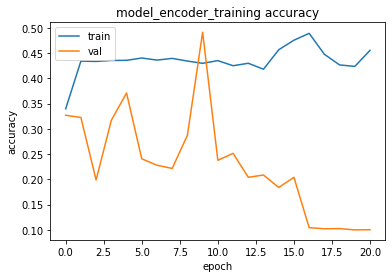

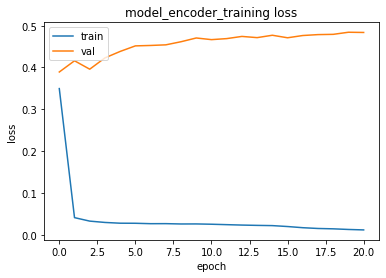

10 examples from test data...
Input                            Expected                         Predicted                           T/F
Accuracy:  0.0
time: 1min 35s (started: 2021-10-21 04:33:19 +00:00)


In [52]:
train_test(model_encoder_training, [X_train, y_train_decode], y_train_padded ,
           [X_test, y_test_decode], 
           y_test_padded, epochs=50, batch_size=10, patience=3,verbose=2)

In [53]:
model_encoder_training.predict([X_test[:1], y_test_decode[:1]])

array([[[ 6.10353351e-01,  6.14157557e-01,  6.11846685e-01,
          6.12735868e-01,  1.38042867e-03,  4.39988635e-03,
         -1.95144123e-04, -1.01479562e-03,  2.84225494e-03,
         -1.37606997e-03],
        [ 6.12902939e-01,  6.15369380e-01,  6.14547133e-01,
          6.15636051e-01,  1.09708123e-03,  7.55282119e-03,
         -2.03275689e-04, -1.14162755e-03,  4.43746336e-03,
         -7.58753682e-04],
        [ 6.09098673e-01,  6.11166596e-01,  6.09599411e-01,
          6.69518650e-01, -1.33833295e-04,  6.57849945e-03,
         -3.44573898e-04, -1.43454713e-03,  2.07019225e-03,
          6.64991327e-04],
        [ 6.08126402e-01,  6.06645167e-01,  6.58942461e-01,
          6.68060124e-01, -6.63890911e-04,  8.55802745e-03,
          7.95161352e-04, -1.97434262e-03,  2.79377028e-03,
          2.16856506e-03],
        [ 6.02022767e-01,  6.55205071e-01,  6.64483428e-01,
          6.63614154e-01, -1.34162174e-03,  1.09827649e-02,
         -3.85953696e-04, -2.57846736e-03, -3.607247

time: 61.1 ms (started: 2021-10-21 04:34:55 +00:00)


In [54]:
y_test_padded[267:]

<tf.Tensor: shape=(1, 10, 10), dtype=float32, numpy=
array([[[0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        ,

time: 7.58 ms (started: 2021-10-21 04:34:55 +00:00)


Begin Inference Model

In [55]:
encoder_model = Model(encoder_inputs, encoder_states)

time: 5.94 ms (started: 2021-10-21 04:34:55 +00:00)


In [56]:
decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder1_outputs, _, _= decoder_lstm1(decoder_inputs,
                                     initial_state=decoder_states_inputs)
decoder_outputs, state_h, state_c = decoder_lstm2(decoder1_outputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

time: 518 ms (started: 2021-10-21 04:34:55 +00:00)


In [59]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 10, 10)) 

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = output_tokens[0, -1, :]
        sampled_char = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_char)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char[-4] <= 0.01):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq[0, 0, :] = sampled_char[:]

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

time: 16.1 ms (started: 2021-10-21 04:35:22 +00:00)


In [60]:
decode_sequence(X_test[:1])

[array([ 0.55994654,  0.6247891 ,  0.5268137 ,  0.5227487 , -0.00193661,
         0.04349741,  0.00362587, -0.01447239, -0.01346128,  0.04373616],
       dtype=float32)]

time: 769 ms (started: 2021-10-21 04:35:23 +00:00)


In [61]:
y_test_padded[:1]

<tf.Tensor: shape=(1, 10, 10), dtype=float32, numpy=
array([[[0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.        ,
         0.        , 0.        , 0.        ,

time: 7.9 ms (started: 2021-10-21 04:35:48 +00:00)
